In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


In [48]:
# TO-DO: Specify the run_id here 
run_id = "251009_5" #"251003_1" #"250929_02" #"250930_1"

In [49]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    # List available experiment names (folders) in the run_id train directory
    exp_dir = os.path.join("..", "results", run_id, "train")
    experiment_names = sorted(
        [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
    )
    print("Available experiments:", experiment_names)

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


In [ ]:
print("GENERATING INFERENCE MAPS FOR RUN ID: ", run_id)
for exp_name in experiment_names:
    sites, cfg = cf.get_config(exp_name)
    global_config = md.global_config
    print("Experiment:", exp_name)

    for site_name, site_paths in sites.items():
        X_patches, Y_patches = [], []
        print("\t-> Site:", site_paths["NAME"])
        Xt, Yt = dt.build_site_data(cfg, site_paths)
        Xp, Yp = dt.extract_patches(Xt, Yt, patch_size=32, fullmap=True)  # (N, C, ps, ps)
        #print(Xt.shape, Yt.shape)
        target_shape = Yt.shape # e.g. (1, 846, 1241)
        X_patches.append(Xp)
        Y_patches.append(Yp)
        X_patches = np.concatenate(X_patches, axis=0)  # (N, C, ps, ps)
        Y_patches = np.concatenate(Y_patches, axis=0)  # (N, C, ps, ps)
        #print(X_patches.shape, Y_patches.shape)

        # Create a full dataset (no splitting, no shuffling)
        full_dataset = md.S2CanopyHeightDataset(X_patches, Y_patches)  # Use full X and Y
        full_loader = md.DataLoader(full_dataset, batch_size=global_config['batch_size'], shuffle=False)  # No shuffle for ordered predictions
        
        # Load the trained model (assuming it's saved; adjust path if needed)
        model = md.build_unet(in_channels=X_patches[0].shape[0], out_channels=Y_patches[0].shape[0])
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        model.load_state_dict(model_weights)
        preds, targets, mask = md.get_predictions_and_targets(full_loader, model, normparams=joint_normparams)
        #print("Preds shape (denormalized), mask shape:", preds.shape, mask.shape)  # Should be (num_patches, C_out, 32, 32)

        # Reconstruct the full prediction map
        pred_map = dt.reconstruct_from_patches(preds, target_shape, patch_size=32, overlap=0)
        mask_map = dt.reconstruct_from_patches(mask, target_shape, patch_size=32, overlap=0)
        #print("Reconstructed pred map shape:", pred_map.shape)

        # apply mask_map (1=valid, 0=invalid) -> set invalid pixels to NaN for plotting
        gt_denorm = md.denorm_chm(Yt, joint_normparams)
        valid = mask_map.astype(bool)
        if pred_map.ndim > 1:  # If multi-channel output, take the first channel, e.g. (C, H, W)
            pred_map = pred_map[0]  # Assuming single channel output
            gt_denorm = gt_denorm[0]
            valid = valid[0]
            pred_map = np.expand_dims(pred_map, axis=0)
            gt_denorm = np.expand_dims(gt_denorm, axis=0)
            valid = np.expand_dims(valid, axis=0)
        else:
            pred_map[~valid] = np.nan
        delta_map = pred_map - gt_denorm

        #raster target transform
        with rasterio.open(site_paths['CHM']) as src:
            target_transform = src.transform
            target_crs = src.crs
        # Save the prediction map as a GeoTIFF
        out_meta = {
            "driver": "GTiff",
            "height": pred_map.shape[1],
            "width": pred_map.shape[2],
            "count": 1,
            "dtype": "float32",
            "crs": target_crs,
            "transform": target_transform,
        }
        out_tif_path = os.path.join("..", "results", run_id, "inference", exp_name, f"{site_name}_pred.tif")
        os.makedirs(os.path.dirname(out_tif_path), exist_ok=True)
        with rasterio.open(out_tif_path, "w", **out_meta) as dest:
            dest.write(pred_map[0], 1)  # Write the first (and only) channel
        out_tif_path_delta = os.path.join("..", "results", run_id, "inference", exp_name, f"{site_name}_delta.tif")
        os.makedirs(os.path.dirname(out_tif_path_delta), exist_ok=True)
        with rasterio.open(out_tif_path_delta, "w", **out_meta) as dest:
            dest.write(delta_map[0], 1)  # Write the first (and only) channel
        out_tif_path_gt = os.path.join("..", "results", run_id, "inference", exp_name, f"{site_name}_gt.tif")
        os.makedirs(os.path.dirname(out_tif_path_gt), exist_ok=True)
        with rasterio.open(out_tif_path_gt, "w", **out_meta) as dest:
            dest.write(gt_denorm[0], 1)  # Write the first (and only) channel
        #print(f"Saved prediction map to {out_tif_path}")
        #break
    #break

GENERATING INFERENCE MAPS FOR RUN ID:  251009_5
Experiment: 01_baseline
	-> Site: Ebrach
	-> Site: Waldbrunn
	-> Site: Berchtesgaden
Experiment: 02_pixel_composites
	-> Site: Ebrach
	-> Site: Waldbrunn
	-> Site: Berchtesgaden
Experiment: 03_seasonal_composites
	-> Site: Ebrach
	-> Site: Waldbrunn
	-> Site: Berchtesgaden
Experiment: 04_pixel_and_seasonal_comp
	-> Site: Ebrach
	-> Site: Waldbrunn
	-> Site: Berchtesgaden
Experiment: 05_support_fmask_dlt
	-> Site: Ebrach
	-> Site: Waldbrunn
	-> Site: Berchtesgaden
Experiment: 06_support_fmask_dlt_dem
	-> Site: Ebrach
	-> Site: Waldbrunn
	-> Site: Berchtesgaden
Experiment: 07_aux_task
	-> Site: Ebrach


IndexError: boolean index did not match indexed array along axis 0; size of axis is 3 but size of corresponding boolean axis is 1

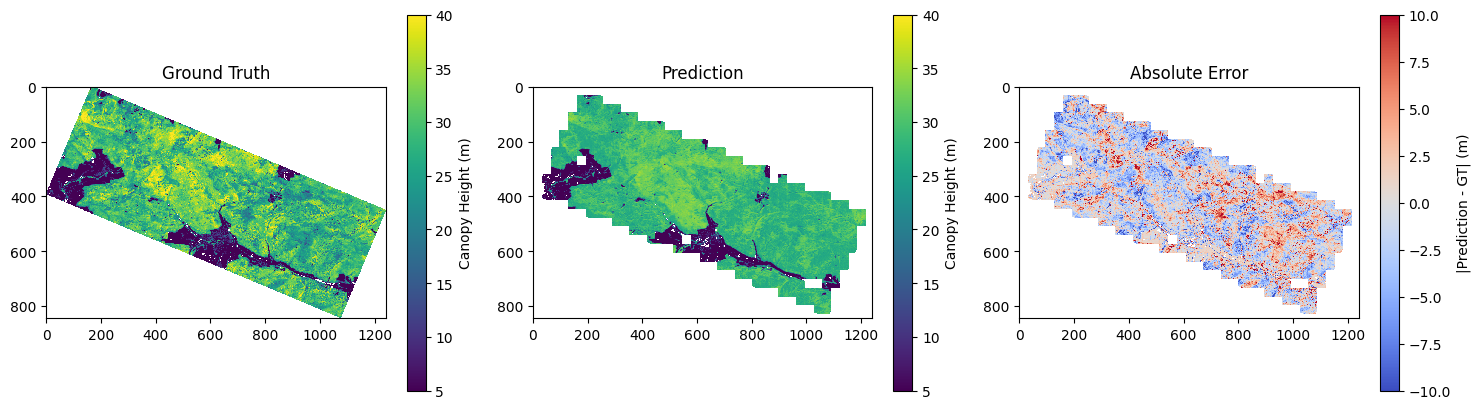

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


# helper to safe-show a 2D array with robust vmin/vmax
def safe_imshow(ax, arr, cmap='viridis', vmin=None, vmax=None, title=None, cb_label=None):
    arr = np.squeeze(np.array(arr))
    if arr.ndim != 2:
        ax.text(0.5, 0.5, 'Not a 2D image', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title or '')
        return
    if not np.isfinite(arr).any():
        ax.text(0.5, 0.5, 'All NaN / no data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title or '')
        return
    try:
        vmin0 = float(np.nanpercentile(arr, 2)) if vmin is None else vmin
        vmax0 = float(np.nanpercentile(arr, 98)) if vmax is None else vmax
    except Exception:
        vmin0, vmax0 = (0.0 if vmin is None else vmin, 1.0 if vmax is None else vmax)
    im = ax.imshow(arr, cmap=cmap, vmin=vmin0, vmax=vmax0, origin='upper', interpolation='nearest')
    ax.set_title(title or '')
    cb = plt.colorbar(im, ax=ax, shrink=0.8)
    if cb_label:
        cb.set_label(cb_label)

# Ground truth (Yt)
safe_imshow(axes[0], gt_denorm[0], cmap='viridis', title='Ground Truth', cb_label='Canopy Height (m)', vmin=5, vmax=40)

# Prediction (pred_map)
# If pred_map was masked to NaN already, this will show the valid areas or a message otherwise.
safe_imshow(axes[1], pred_map[0], cmap='viridis', title='Prediction', cb_label='Canopy Height (m)', vmin=5, vmax=40)

# Delta map (absolute error)
delta_map = (pred_map - gt_denorm)
safe_imshow(axes[2], delta_map[0], cmap='coolwarm', title='Absolute Error', cb_label='|Prediction - GT| (m)', vmin=-10, vmax=10)
# #safe_imshow(axes[2], mask_map[0], cmap='gray', vmin=0, vmax=1, title='Mask', cb_label='Valid (1) / Invalid (0)')

plt.tight_layout()
plt.show()

In [32]:
test = 2

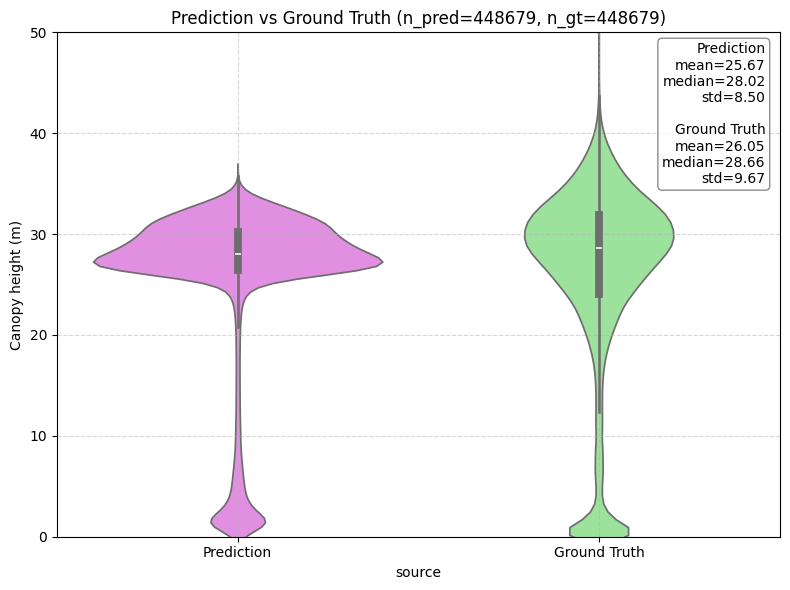

In [42]:
import seaborn as sns

# Use paired finite values where both pred and gt are valid, fall back to independent sets
paired_mask = np.isfinite(pred_map) & np.isfinite(gt_denorm)
if paired_mask.any():
    pred_vals = pred_map[paired_mask].ravel()
    gt_vals = gt_denorm[paired_mask].ravel()
else:
    pred_vals = pred_map[np.isfinite(pred_map)].ravel()
    gt_vals = gt_denorm[np.isfinite(gt_denorm)].ravel()

if pred_vals.size == 0 or gt_vals.size == 0:
    print("No finite values found for prediction and/or ground truth.")
else:
    # Subsample large arrays for plotting speed
    max_samples = 1000000
    rng = np.random.default_rng(0)
    if pred_vals.size > max_samples:
        pred_vals = rng.choice(pred_vals, max_samples, replace=False)
    if gt_vals.size > max_samples:
        gt_vals = rng.choice(gt_vals, max_samples, replace=False)

    # build tidy dataframe for seaborn
    df = pd.DataFrame({
        "value": np.concatenate([pred_vals, gt_vals]),
        "source": ["Prediction"] * pred_vals.size + ["Ground Truth"] * gt_vals.size,
    })

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.violinplot(x="source", y="value", data=df, ax=ax, inner="box",
                   palette=["violet", "lightgreen"], hue="source", dodge=False,
                   common_norm=True, fill=True)
    ax.set_ylabel("Canopy height (m)")
    ax.set_title(f"Prediction vs Ground Truth (n_pred={pred_vals.size}, n_gt={gt_vals.size})")
    ax.set_ylim(0, 50)
    # Annotate basic stats
    def stats(arr):
        return float(np.nanmean(arr)), float(np.nanmedian(arr)), float(np.nanstd(arr))

    p_mean, p_med, p_std = stats(pred_vals)
    g_mean, g_med, g_std = stats(gt_vals)
    stats_text = (
        f"Prediction\nmean={p_mean:.2f}\nmedian={p_med:.2f}\nstd={p_std:.2f}\n\n"
        f"Ground Truth\nmean={g_mean:.2f}\nmedian={g_med:.2f}\nstd={g_std:.2f}"
    )
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
            ha="right", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## test with orthophoto overlay

Prediction map shape: (1870, 2129) CRS: EPSG:25832
Orthophoto shape: (3, 2500, 2500) CRS: EPSG:25832


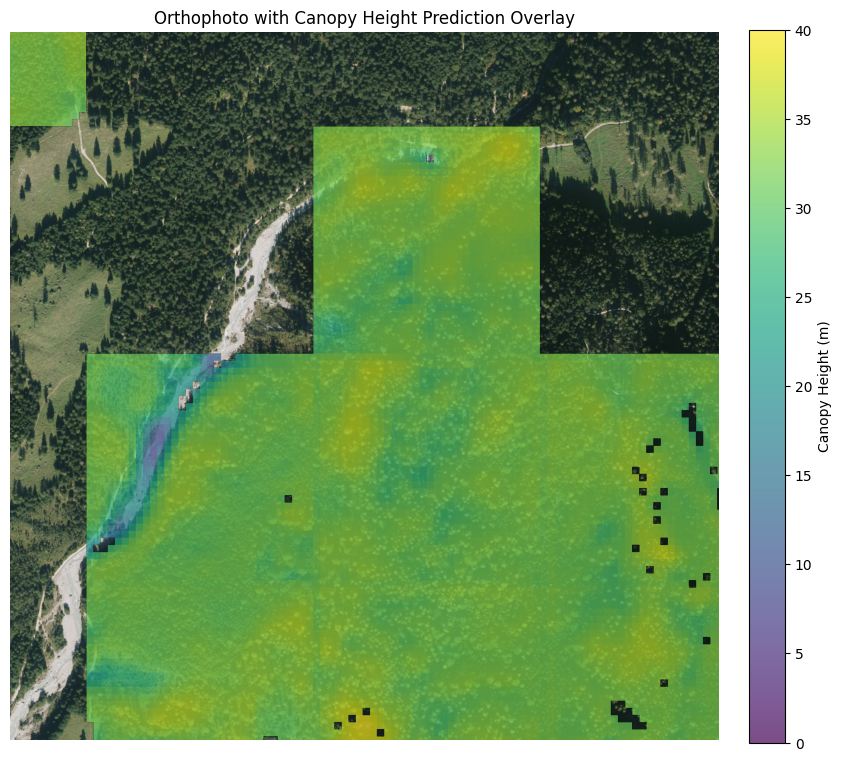

In [ ]:
# photo directory
photo_dir = "../data/04_orthophoto/berch"
photo_tif = glob.glob(os.path.join(photo_dir, "*.tif"))

run_id = "251009_5"
exp_name = "03_seasonal_composites"
site_name = "SITE3"
# load the prediction map
pred_tif_path = os.path.join("..", "results", run_id, "inference", exp_name, f"{site_name}_pred.tif")
gt_tif_path = os.path.join("..", "results", run_id, "inference", exp_name, f"{site_name}_gt.tif")

gt_raster = rasterio.open(gt_tif_path)
gt_map = gt_raster.read(1)  # (H, W)
pred_raster = rasterio.open(pred_tif_path)
pred_map = pred_raster.read(1)  # (H, W)
pred_transform = pred_raster.transform
pred_crs = pred_raster.crs

photo_raster = rasterio.open(photo_tif[0])
photo = photo_raster.read()  # (C, H, W)
photo_transform = photo_raster.transform
photo_crs = photo_raster.crs

print("Prediction map shape:", pred_map.shape, "CRS:", pred_crs)
print("Orthophoto shape:", photo.shape, "CRS:", photo_crs)
#print("Prediction transform:", pred_transform, "Orthophoto transform:", photo_transform)

# #plot the orthophoto
# plt.imshow(np.moveaxis(photo, 0, -1))
# plt.title("Orthophoto")
# plt.axis('off')
# plt.show()

#now plot an overlyay of the prediction on the orthophoto
# Reproject prediction map to match orthophoto
reprojected_pred = np.empty((photo.shape[1], photo.shape[2]), dtype=np.float32)
reproject(
    source=pred_map,
    destination=reprojected_pred,
    src_transform=pred_transform,
    src_crs=pred_crs,
    dst_transform=photo_transform,
    dst_crs=photo_crs,
    resampling=Resampling.nearest
)
reprojected_gt = np.empty((photo.shape[1], photo.shape[2]), dtype=np.float32)
reproject(
    source=gt_map,
    destination=reprojected_gt,
    src_transform=pred_transform,
    src_crs=pred_crs,
    dst_transform=photo_transform,
    dst_crs=photo_crs,
    resampling=Resampling.nearest
)

# Plot orthophoto with prediction overlay and gt overlay, 2 subplots
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(np.moveaxis(photo, 0, -1))
plt.imshow(reprojected_pred, cmap='viridis', alpha=0.7, vmin=0, vmax=40)  # Adjust alpha for transparency
plt.title("Orthophoto with Canopy Height Prediction Overlay")

plt.subplot(1, 2, 2)
plt.imshow(np.moveaxis(photo, 0, -1))
plt.imshow(reprojected_gt, cmap='viridis', alpha=0.7, vmin=0, vmax=40)  # Adjust alpha for transparency
plt.title("Orthophoto with Canopy Height Ground Truth Overlay")
plt.axis('off')
plt.colorbar(label='Canopy Height (m)', fraction=0.046, pad=0.04)

plt.show()

